In [ ]:
!unzip -qq /content/CovidXRayImages.zip

In [ ]:
import subprocess
import os

In [ ]:
!rm -r "/content/Val/COVID-19/lung masks"

In [ ]:
!rm -r "/content/Val/Non-COVID/lung masks"

In [ ]:
!rm -r "/content/Val/Normal/lung masks"

In [ ]:
!pip install -q lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries, felzenszwalb

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

In [ ]:
covid_path = "/content/Val/COVID-19/images"
print("covid file len: ", len(os.listdir(covid_path)))

Non_covid_path = "/content/Val/Non-COVID/images"
print("Non covid file len: ", len(os.listdir(Non_covid_path)))

Normal_path = "/content/Val/Normal/images"
print("Normal file len: ", len(os.listdir(Normal_path)))

covid file len:  1903
Non covid file len:  1802
Normal file len:  1712


In [ ]:
Path = "/content/Val/"
Batch_size = 32
target_size = (256,256)
classes = ["COVID-19", "Non-COVID", "Normal"]

image_data = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.1
)

train_data = image_data.flow_from_directory(
    Path,
    target_size = target_size,
    color_mode = 'grayscale',
    class_mode = "categorical",
    classes = classes,
    batch_size = Batch_size,
    subset = "training",
    keep_aspect_ratio = True,
    shuffle = True
)

test_data = image_data.flow_from_directory(
    Path,
    target_size = target_size,
    color_mode = 'grayscale',
    class_mode = "categorical",
    classes = classes,
    batch_size = Batch_size,
    subset = "validation",
    keep_aspect_ratio = True,
    shuffle = True
)


Found 4876 images belonging to 3 classes.
Found 541 images belonging to 3 classes.


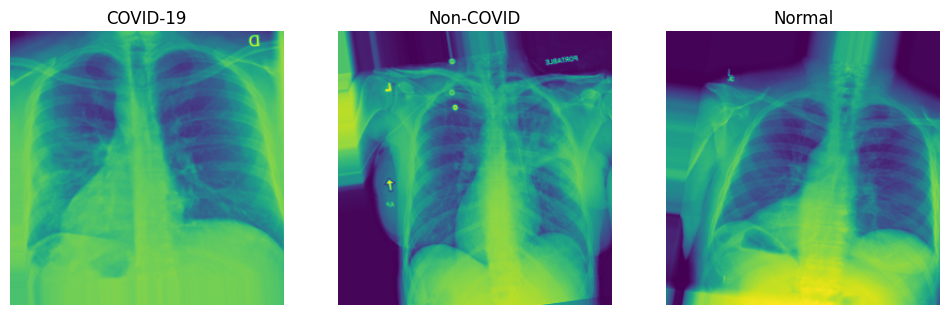

In [ ]:
#Function to display an image of respective each class
def plot_images(data, classes):
    #to fetch the batch of images and labels
    images, labels = next(data)
    labels = np.argmax(labels, axis=-1)

    #create a figsize
    plt.figure(figsize=(12,4))

    #need to go through each class
    for i,className in enumerate(classes):
        #Get the index of 1st image in the particular class
        class_index = np.where(labels == i)[0]
        if len(class_index) > 0:
            img = images[class_index[0]]
        else:
            continue

        #plotting the image
        plt.subplot(1, len(classes), i + 1)
        plt.imshow(img)
        plt.title(className)
        plt.axis('off')

    plt.show()

#Get the name of class from train data
classNames = list(train_data.class_indices.keys())

#plot the image
plot_images(train_data,classNames)

In [ ]:
for img, label in train_data:
    print(set(label.argmax(axis=-1)))
    break

{0, 1, 2}


In [ ]:
img.shape

(32, 256, 256, 1)

In [ ]:
# A map done by ImageDataGenarot for each class
class_labels = train_data.class_indices

In [ ]:
model_2 = Sequential()
#Convolutional Layer
model_2.add(Conv2D(filters=16, kernel_size = 3, input_shape = (256,256,1), padding = "same", activation="relu"))

#Pooling layer
model_2.add(MaxPooling2D(pool_size=(2,2)))

#Convolutional Layer
model_2.add(Conv2D(filters=64, kernel_size = 3, padding = "same", activation="relu"))

#Pooling Layer
model_2.add(MaxPooling2D())

#Convolutional Layer
model_2.add(Conv2D(filters=128, kernel_size = 3, padding = "same", activation="relu"))

#Pooling Layer
model_2.add(MaxPooling2D())

#Flatten Layer
model_2.add(Flatten())

#Fully connected layer
model_2.add(Dense(128,activation="relu"))
model_2.add(Dense(128,activation="relu"))

#Output Layer
model_2.add(Dense(3,activation="softmax"))

model_2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      9280      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 128)       0

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=4
)

model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    'model1.keras',
    save_weights_only = True,
    monitor='val_accuracy'
)

history = model_2.fit(train_data, epochs = 20, validation_data=test_data, callbacks=[early_stop, model_ckpt])

Epoch 1/20
153/153 [==============================] - 48s 271ms/step - loss: 0.9797 - accuracy: 0.5191 - val_loss: 0.7479 - val_accuracy: 0.6543
Epoch 2/20
153/153 [==============================] - 38s 251ms/step - loss: 0.8450 - accuracy: 0.6179 - val_loss: 0.6660 - val_accuracy: 0.7320
Epoch 3/20
153/153 [==============================] - 40s 259ms/step - loss: 0.7733 - accuracy: 0.6530 - val_loss: 0.6323 - val_accuracy: 0.7320
Epoch 4/20
153/153 [==============================] - 38s 251ms/step - loss: 0.7216 - accuracy: 0.6885 - val_loss: 0.7249 - val_accuracy: 0.6987
Epoch 5/20
153/153 [==============================] - 39s 252ms/step - loss: 0.6820 - accuracy: 0.7084 - val_loss: 0.6334 - val_accuracy: 0.7412
Epoch 6/20
153/153 [==============================] - 40s 259ms/step - loss: 0.6347 - accuracy: 0.7348 - val_loss: 0.6318 - val_accuracy: 0.7394
Epoch 7/20
153/153 [==============================] - 38s 250ms/step - loss: 0.6200 - accuracy: 0.7422 - val_loss: 0.5547 - val_ac

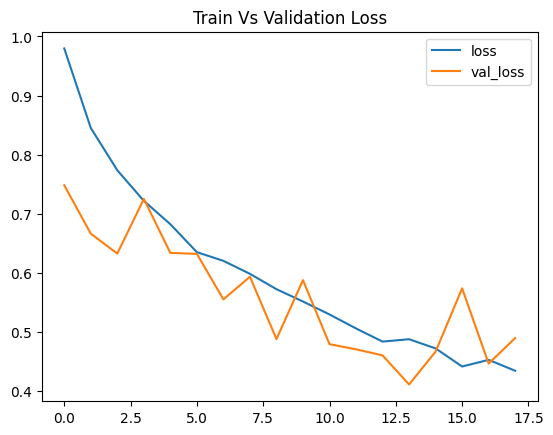

In [ ]:
plt.title("Train Vs Validation Loss")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

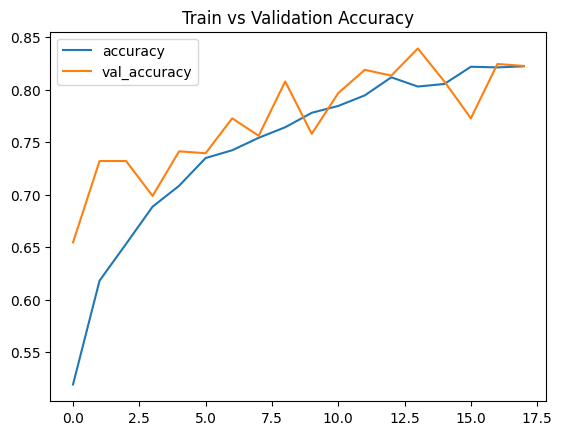

In [ ]:
plt.title("Train vs Validation Accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
def predict(model, validation_data, steps):
    true_proba = []
    pred_proba = []

    for index, (inp_image, gt_label) in enumerate(validation_data):
        if index > steps:
            break
        true_proba.extend(gt_label)

        model_pred = model.predict(inp_image, verbose=0)

        pred_proba.extend(model_pred)

    true_proba = np.array(true_proba)
    pred_proba = np.array(pred_proba)

    return true_proba, pred_proba

In [ ]:
steps = len(test_data)
true_proba, pred_proba = predict(model_2, test_data, steps)

In [ ]:
print(true_proba.shape)
print(pred_proba.shape)

(570, 3)
(570, 3)


In [ ]:
# Convert probability to integer label
true_label = np.argmax(true_proba, axis=-1)
pred_label = np.argmax(pred_proba, axis=-1)

In [ ]:
def draw_confusion_matrix(conf_matrix, labels):
    plt.title("Confusion Matrix")
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Prediction")
    plt.ylabel("Ground Truth")
    plt.show()

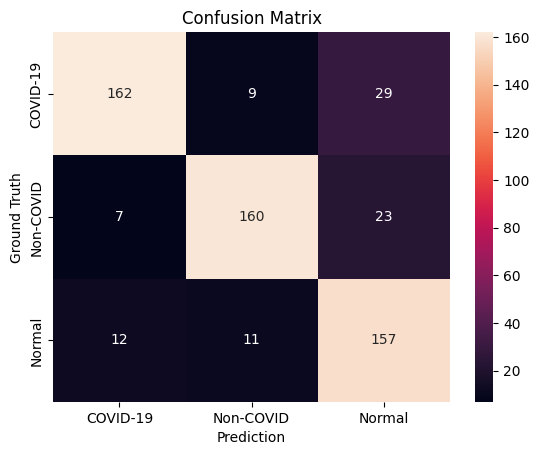

In [ ]:
conf_mat = confusion_matrix(true_label, pred_label)
draw_confusion_matrix(conf_mat, class_labels.keys())

In [ ]:
def draw_auc_roc_curve(y_true, y_pred, labels):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i, label in enumerate(labels):
        fpr[label], tpr[label], threshold = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[label] = auc(fpr[label], tpr[label])

    # Micro-average ROC Curve
    fpr["micro"], tpr["micro"], threshold = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc['micro'] = auc(fpr["micro"], tpr["micro"])

    plt.plot(fpr["micro"], tpr["micro"], label=f"Micro ROC curve (area={roc_auc['micro']:.2f})")

    # Draw curve for each label and micro
    for label in labels:
        plt.plot(fpr[label], tpr[label], label=f'ROC Cuve for {label} (area={roc_auc[label]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()

    plt.show()

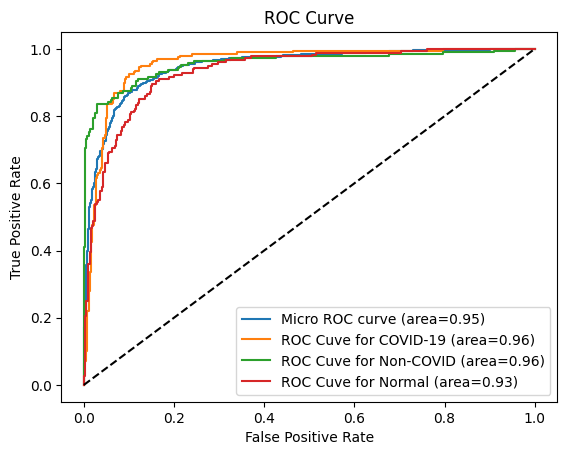

In [ ]:
draw_auc_roc_curve(true_proba, pred_proba, class_labels.keys())

1/1 [==============================] - 0s 94ms/step


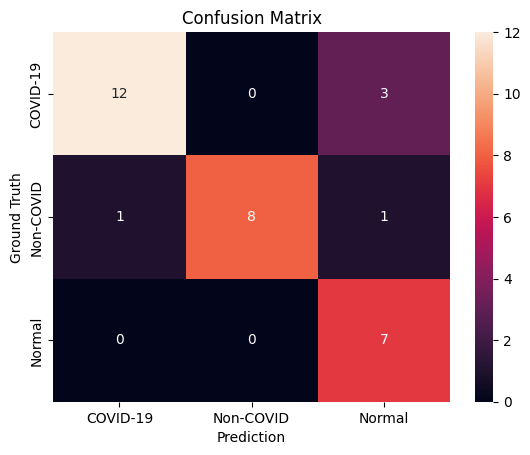

In [ ]:
# Get sample data for doing model interpretability
for inp_image, true_probs in test_data:
    pred_probs = model_2.predict(inp_image)
    break

true_lab = np.argmax(true_probs, axis=-1)
pred_lab = np.argmax(pred_probs, axis=-1)

conf_matrix = confusion_matrix(true_lab, pred_lab)
draw_confusion_matrix(conf_matrix, class_labels.keys())

In [ ]:
# Get the False Negative for COVID-19 against Normal
covid_fn_normal = true_lab == class_labels['COVID-19']
covid_fn_normal *= (pred_lab == class_labels['Normal'])
covid_fn_normal_images = inp_image[covid_fn_normal]

# Get the False Negative for Non-COVID against Normal
non_covid_fn_normal = true_lab == class_labels['Non-COVID']
non_covid_fn_normal *= (pred_lab == class_labels['Normal'])
non_covid_fn_normal_images = inp_image[non_covid_fn_normal]

In [ ]:
def lime_predict_model_2(image):
    return model_2.predict(image)

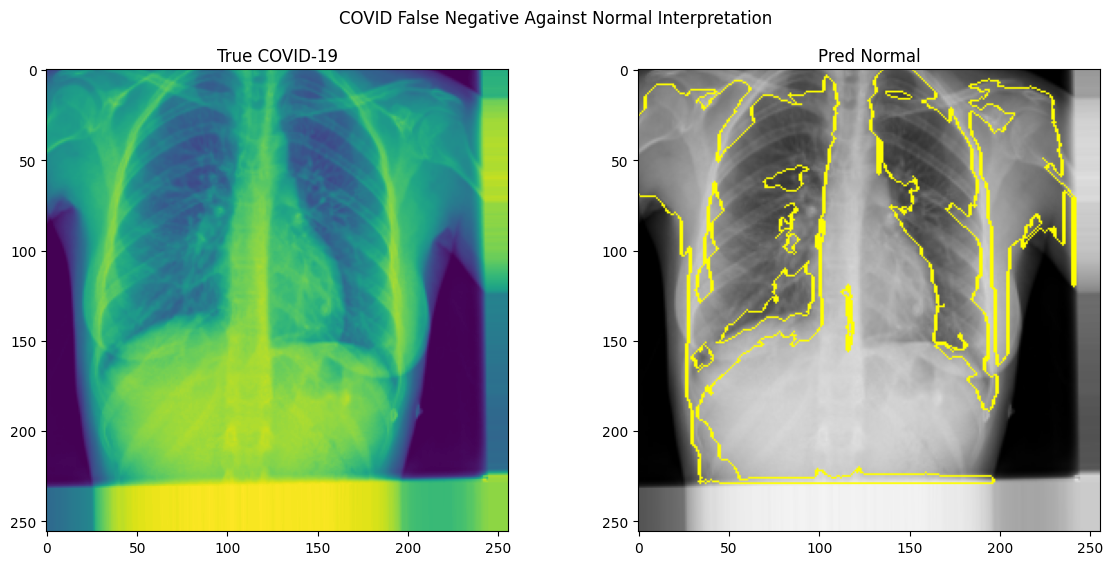

In [ ]:
image = covid_fn_normal_images[0]

image_exp = lime_image.LimeImageExplainer()

image_explanation = image_exp.explain_instance(
    image,
    lime_predict_model_2,
    top_labels = len(class_labels),
    hide_color=0,
    num_samples=1000,
    segmentation_fn=lambda x: felzenszwalb(x, scale=100, sigma=0.5, min_size=50)
)

img, mask = image_explanation.get_image_and_mask(image_explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("COVID False Negative Against Normal Interpretation")

axes[0].imshow(image, cmap="gray")
axes[0].set_title("True COVID-19")

img_3ch = np.repeat(img, repeats=3, axis=-1)
plt.imshow(mark_boundaries(img_3ch, mask))

axes[1].imshow(mark_boundaries(img_3ch, mask))
axes[1].set_title("Pred Normal")
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


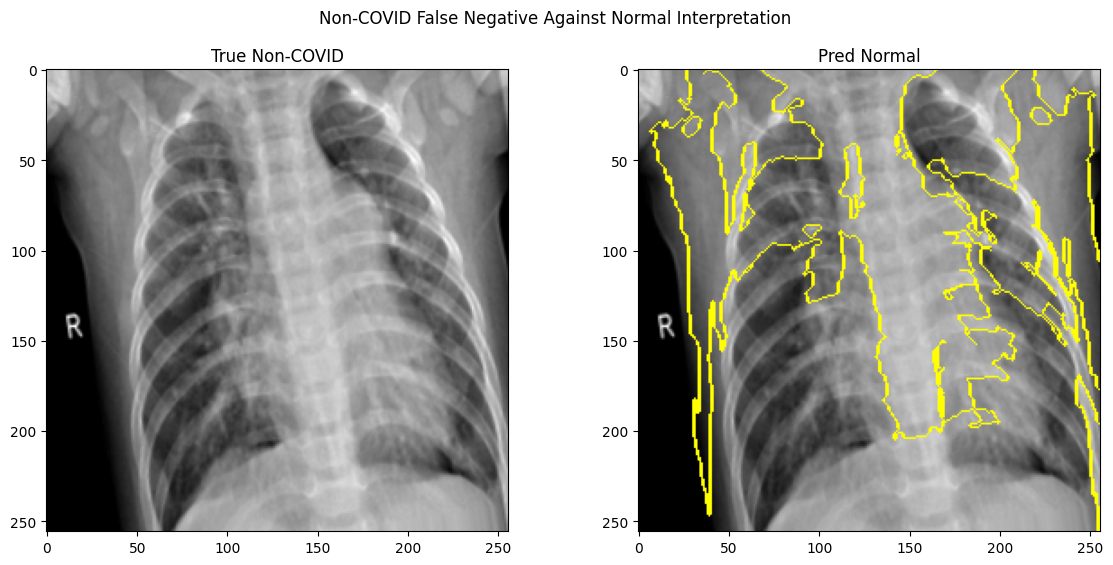

In [ ]:
image = non_covid_fn_normal_images[0]

image_exp = lime_image.LimeImageExplainer()

image_explanation = image_exp.explain_instance(
    image,
    lime_predict_model_2,
    top_labels = len(class_labels),
    hide_color=0,
    num_samples=1000,
    segmentation_fn=lambda x: felzenszwalb(x, scale=100, sigma=0.5, min_size=50)
)

img, mask = image_explanation.get_image_and_mask(image_explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Non-COVID False Negative Against Normal Interpretation")

axes[0].imshow(image, cmap="gray")
axes[0].set_title("True Non-COVID")

img_3ch = np.repeat(img, repeats=3, axis=-1)
plt.imshow(mark_boundaries(img_3ch, mask))

axes[1].imshow(mark_boundaries(img_3ch, mask))
axes[1].set_title("Pred Normal")
plt.show()

It can be seen that for COVID the model was considering the correct area and making a prediction although being wrong. That is the case of underfitting and hence we can increase the model dimension to capture more data from the image.

For the fine-tune we will have the stride = 2 and with more covolution layers to extract more features from the image

In [ ]:
model_3 = Sequential()
#Convolutional Layer
model_3.add(Conv2D(filters=16, kernel_size = 3, input_shape = (256,256,1), strides=2, padding = "same", activation="relu"))

#Convolutional Layer
model_3.add(Conv2D(filters=64, kernel_size = 3, strides=2,  padding = "same", activation="relu"))

#Convolutional Layer
model_3.add(Conv2D(filters=128, kernel_size = 3, strides=2,  padding = "same", activation="relu"))

#Convolutional Layer
model_3.add(Conv2D(filters=256, kernel_size = 3, strides=2,  padding = "same", activation="relu"))

#Flatten Layer
model_3.add(Flatten())

#Fully connected layer
model_3.add(Dense(128,activation="relu"))
model_3.add(Dense(128,activation="relu"))

#Output Layer
model_3.add(Dense(3,activation="softmax"))

model_3.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model_3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 128, 128, 16)      160       
                                                                 
 conv2d_24 (Conv2D)          (None, 64, 64, 64)        9280      
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 256)       295168    
                                                                 
 flatten_6 (Flatten)         (None, 65536)             0         
                                                                 
 dense_18 (Dense)            (None, 128)               8388736   
                                                                 
 dense_19 (Dense)            (None, 128)              

In [ ]:
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    'model3.keras',
    save_weights_only = True,
    monitor='val_accuracy'
)

history = model_3.fit(train_data, epochs = 40, validation_data=test_data, callbacks=[model_ckpt])

Epoch 1/40
153/153 [==============================] - 40s 242ms/step - loss: 1.0133 - accuracy: 0.4930 - val_loss: 0.8322 - val_accuracy: 0.6784
Epoch 2/40
153/153 [==============================] - 35s 228ms/step - loss: 0.9013 - accuracy: 0.5759 - val_loss: 0.7117 - val_accuracy: 0.7024
Epoch 3/40
153/153 [==============================] - 37s 245ms/step - loss: 0.8434 - accuracy: 0.6269 - val_loss: 0.6020 - val_accuracy: 0.7597
Epoch 4/40
153/153 [==============================] - 42s 274ms/step - loss: 0.8018 - accuracy: 0.6544 - val_loss: 0.6000 - val_accuracy: 0.7560
Epoch 5/40
153/153 [==============================] - 35s 231ms/step - loss: 0.7483 - accuracy: 0.6737 - val_loss: 0.6651 - val_accuracy: 0.7301
Epoch 6/40
153/153 [==============================] - 36s 238ms/step - loss: 0.6984 - accuracy: 0.7043 - val_loss: 0.6108 - val_accuracy: 0.7597
Epoch 7/40
153/153 [==============================] - 38s 249ms/step - loss: 0.6843 - accuracy: 0.7104 - val_loss: 0.6122 - val_ac

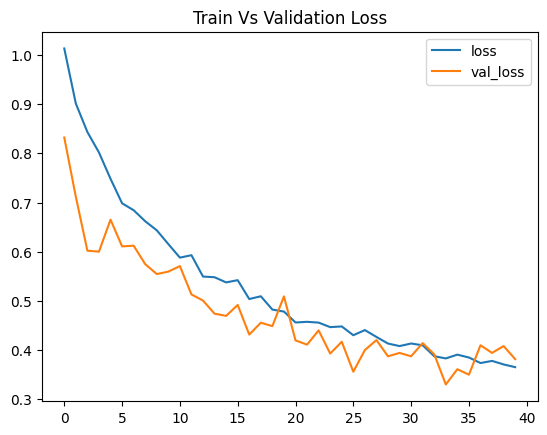

In [ ]:
plt.title("Train Vs Validation Loss")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

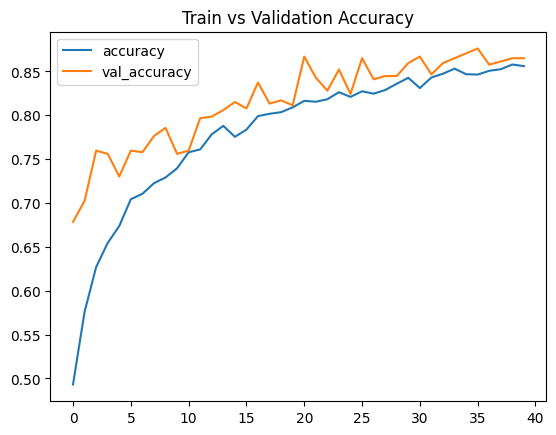

In [ ]:
plt.title("Train vs Validation Accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
steps = len(test_data)
true_proba, pred_proba = predict(model_3, test_data, steps)

true_label = np.argmax(true_proba, axis=-1)
pred_label = np.argmax(pred_proba, axis=-1)

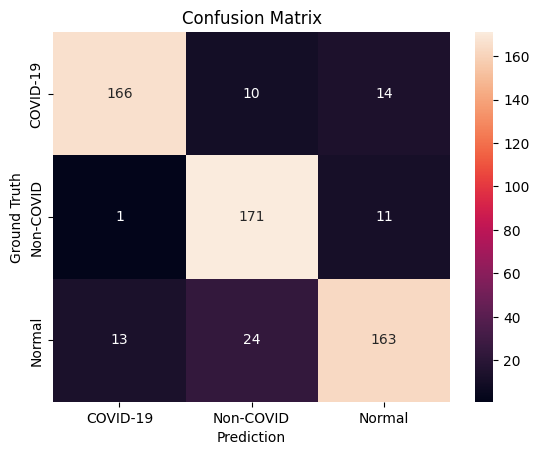

In [ ]:
conf_mat = confusion_matrix(true_label, pred_label)
draw_confusion_matrix(conf_mat, class_labels.keys())

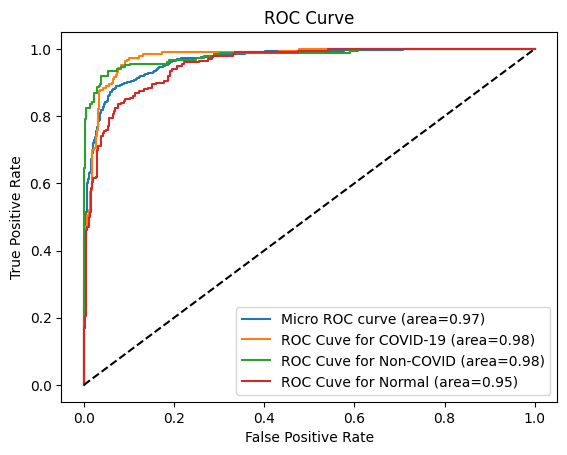

In [ ]:
draw_auc_roc_curve(true_proba, pred_proba, class_labels.keys())

1/1 [==============================] - 0s 20ms/step


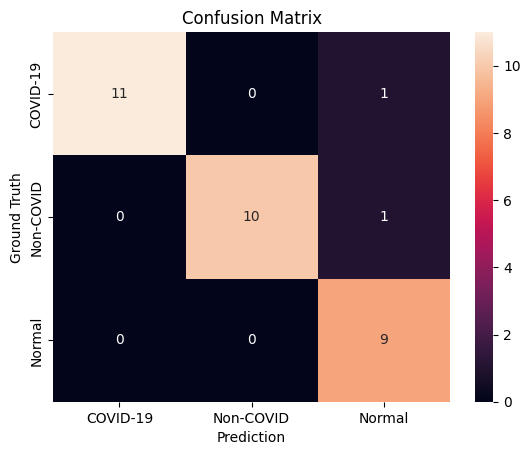

In [ ]:
for inp_image, true_probs in test_data:
    pred_probs = model_2.predict(inp_image)
    break

true_lab = np.argmax(true_probs, axis=-1)
pred_lab = np.argmax(pred_probs, axis=-1)

conf_matrix = confusion_matrix(true_lab, pred_lab)
draw_confusion_matrix(conf_matrix, class_labels.keys())

In [ ]:
# Get True Positive for COVID-19 to compare the result against
covid_tp_covid = true_lab == class_labels['COVID-19']
covid_tp_covid *= (pred_lab == class_labels['COVID-19'])
covid_tp_covid_images = inp_image[covid_tp_covid]

# Get the False Negative for COVID-19 against Normal
covid_fn_normal = true_lab == class_labels['COVID-19']
covid_fn_normal *= (pred_lab == class_labels['Normal'])
covid_fn_normal_images = inp_image[covid_fn_normal]

# Get True Positive for Non-COVID
non_covid_tp_non_covid = true_lab == class_labels['Non-COVID']
non_covid_tp_non_covid *= (pred_lab == class_labels['Non-COVID'])
non_covid_tp_non_covid_images = inp_image[non_covid_tp_non_covid]

# Get the False Negative for Non-COVID against Normal
non_covid_fn_normal = true_lab == class_labels['Non-COVID']
non_covid_fn_normal *= (pred_lab == class_labels['Normal'])
non_covid_fn_normal_images = inp_image[non_covid_fn_normal]

In [ ]:
def lime_predict_model_3(image):
    return model_3.predict(image)

In [ ]:
image = covid_tp_covid_images[0]

image_exp = lime_image.LimeImageExplainer()

image_explanation = image_exp.explain_instance(
    image,
    lime_predict_model_3,
    top_labels = len(class_labels),
    hide_color=0,
    num_samples=1000,
    segmentation_fn=lambda x: felzenszwalb(x, scale=100, sigma=0.5, min_size=50)
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


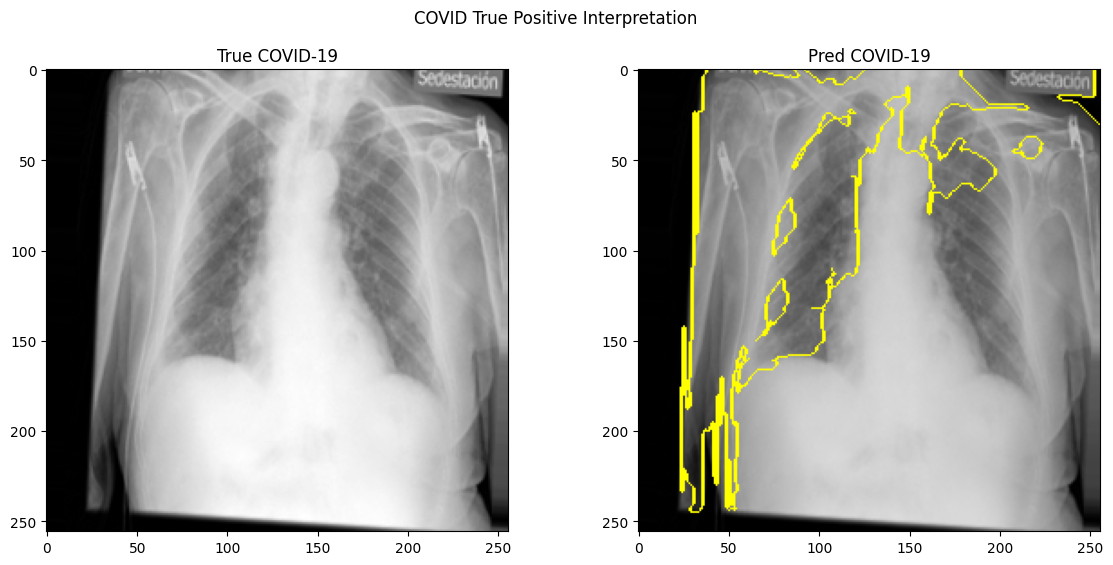

In [ ]:
img, mask = image_explanation.get_image_and_mask(image_explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("COVID True Positive Interpretation")

axes[0].imshow(image, cmap="gray")
axes[0].set_title("True COVID-19")

img_3ch = np.repeat(img, repeats=3, axis=-1)
plt.imshow(mark_boundaries(img_3ch, mask))

axes[1].imshow(mark_boundaries(img_3ch, mask))
axes[1].set_title("Pred COVID-19")
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


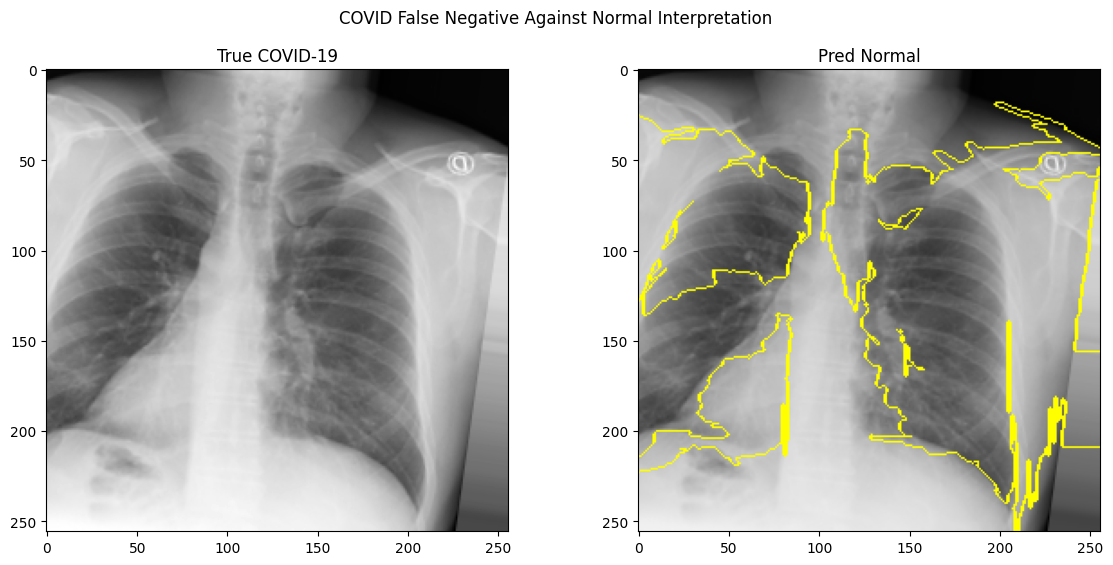

In [ ]:
image = covid_fn_normal_images[0]

image_exp = lime_image.LimeImageExplainer()

image_explanation = image_exp.explain_instance(
    image,
    lime_predict_model_3,
    top_labels = len(class_labels),
    hide_color=0,
    num_samples=1000,
    segmentation_fn=lambda x: felzenszwalb(x, scale=100, sigma=0.5, min_size=50)
)

img, mask = image_explanation.get_image_and_mask(image_explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("COVID False Negative Against Normal Interpretation")

axes[0].imshow(image, cmap="gray")
axes[0].set_title("True COVID-19")

img_3ch = np.repeat(img, repeats=3, axis=-1)
plt.imshow(mark_boundaries(img_3ch, mask))

axes[1].imshow(mark_boundaries(img_3ch, mask))
axes[1].set_title("Pred Normal")
plt.show()

As compare to the True Positive COVID the model is considering more region to predict it as Normal.

In [ ]:
image = non_covid_tp_non_covid_images[0]

image_exp = lime_image.LimeImageExplainer()

image_explanation = image_exp.explain_instance(
    image,
    lime_predict_model_2,
    top_labels = len(class_labels),
    hide_color=0,
    num_samples=1000,
    segmentation_fn=lambda x: felzenszwalb(x, scale=100, sigma=0.5, min_size=50)
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


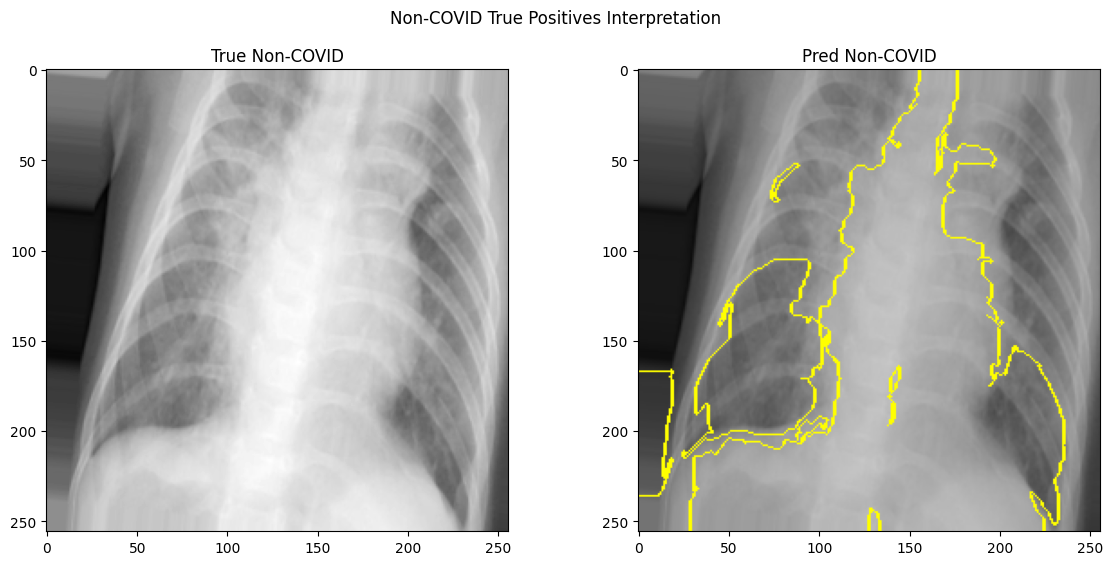

In [ ]:
img, mask = image_explanation.get_image_and_mask(image_explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Non-COVID True Positives Interpretation")

axes[0].imshow(image, cmap="gray")
axes[0].set_title("True Non-COVID")

img_3ch = np.repeat(img, repeats=3, axis=-1)
plt.imshow(mark_boundaries(img_3ch, mask))

axes[1].imshow(mark_boundaries(img_3ch, mask))
axes[1].set_title("Pred Non-COVID")
plt.show()

In [ ]:
image = non_covid_fn_normal_images[0]

image_exp = lime_image.LimeImageExplainer()

image_explanation = image_exp.explain_instance(
    image,
    lime_predict_model_2,
    top_labels = len(class_labels),
    hide_color=0,
    num_samples=1000,
    segmentation_fn=lambda x: felzenszwalb(x, scale=100, sigma=0.5, min_size=50)
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


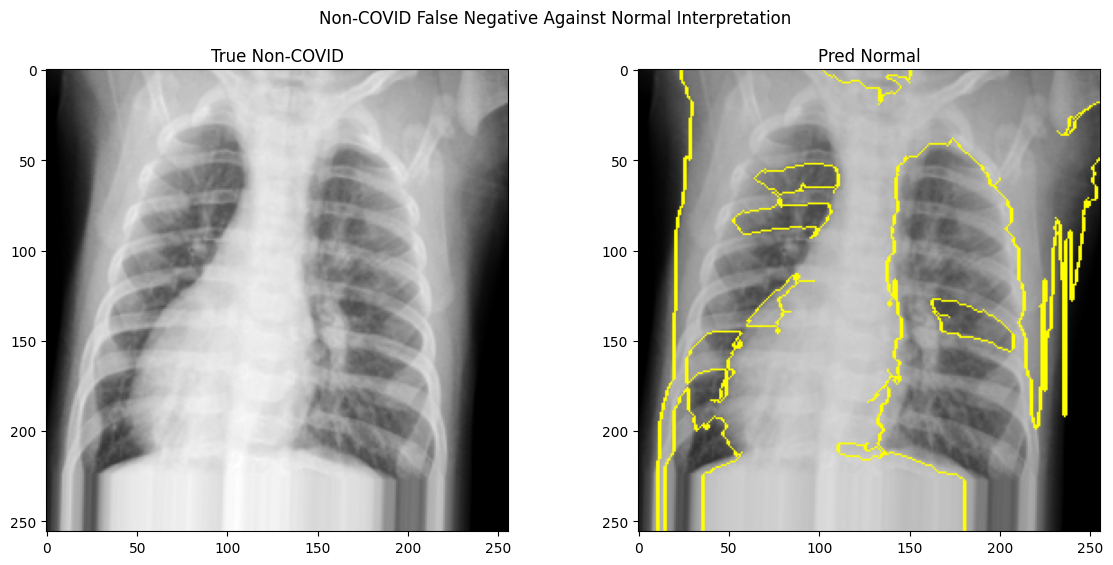

In [ ]:
img, mask = image_explanation.get_image_and_mask(image_explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Non-COVID False Negative Against Normal Interpretation")

axes[0].imshow(image, cmap="gray")
axes[0].set_title("True Non-COVID")

img_3ch = np.repeat(img, repeats=3, axis=-1)
plt.imshow(mark_boundaries(img_3ch, mask))

axes[1].imshow(mark_boundaries(img_3ch, mask))
axes[1].set_title("Pred Normal")
plt.show()

From the model's focus region plot it is understandable that the model is able to get the features around the lungs which is what we want it to do but still sometimes it make wrong prediction.

## Future Work
Over here the model is providing focus on right place to make prediction, although, not utmost perfect but on a general level it is able to derive the correct regions but still it ends up in mis-prediction.

Also the training and testing accuracy as well as loss was still converging toward their optimal state so we can increase the model dimension and make the model more complex and traing it for longer time to make the model more robust and make it provide acceptable answer.